# Black-Scholes implementation

### Step 1) *Data prep as described [Here](http://localhost:8888/files/Desktop/Tesi%20Borri/Data%20preparation.ipynb?_xsrf=2%7Ce5b511d0%7C653ab010e3f3fffbd39d614750c07f88%7C1598287506)*

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd
import numpy as np
import sympy as sy
import scipy.stats as si
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import math
import seaborn as sns
import time
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

ds=pd.read_csv('c:/L3_options_20190815.csv')

#Deleting the unused columns
ds.drop('Volume', axis=1, inplace=True)
ds.drop('OpenInterest', axis=1, inplace=True)
ds.drop('T1OpenInterest', axis=1, inplace=True)
ds.drop('IVBid', axis=1, inplace=True)
ds.drop('IVAsk', axis=1, inplace=True)
ds.drop('AKA', axis=1, inplace=True)
ds.drop('UnderlyingSymbol', axis=1, inplace=True)
ds.drop('Flags', axis=1, inplace=True)

#Creating the target variable 'Price' as the average of Bid and Ask price

ds['Average Price']=(ds['Bid']+ds['Ask'])/2

ds.drop('Bid', axis=1, inplace=True)
ds.drop('Ask', axis=1, inplace=True)

#Creating the variable 'Time to maturity' as a fraction of 252 yearly working days

date_format = "%m/%d/%Y"
ds['StartDay'] = pd.to_datetime(ds[' DataDate']).sub(pd.Timestamp('2019-01-01')).dt.days
ds['ExpirationDay'] = pd.to_datetime(ds['Expiration']).sub(pd.Timestamp('2019-01-01')).dt.days
ds['TimeToMaturity'] = (ds['ExpirationDay'] - ds['StartDay'])/252

#Risk Free rate, the US 3 months treasury bill rate

rf = 0.0187 

#Deleting all the remaining unused columns

ds.drop('Expiration', axis=1, inplace=True)
ds.drop(' DataDate', axis=1, inplace=True)
ds.drop('Last', axis=1, inplace=True)
ds.drop('Delta', axis=1, inplace=True)
ds.drop('Gamma', axis=1, inplace=True)
ds.drop('Theta', axis=1, inplace=True)
ds.drop('Vega', axis=1, inplace=True)
ds.drop('StartDay', axis=1, inplace=True)
ds.drop('ExpirationDay', axis=1, inplace=True)
ds.drop('OptionSymbol', axis=1, inplace=True)

#Dividing observations in test set and training set

train_ds = ds.sample(frac=0.8,random_state=0)
test_ds = ds.drop(train_ds.index)

print(str(len(train_ds))+" train observations")
print(str(len(test_ds))+" test observations")

742939 train observations
185735 test observations


### Step 2) *Defining Black-Scholes formula fro european Calls and Puts*

In [5]:
#Defining Black and Scholes formula

def BS_Option_Price(S, K, T, r, sigma, option = 'call'):
    
    #S: Underlying price
    #K: Strike price
    #T: Time to maturity
    #r: Risk free rate
    #sigma: Implied Volatility
    
    #d_1 and d_2
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T)) 
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if option == 'call':
        result = (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    if option == 'put':
        result = (K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1))
        
    return result

### Step 3) *Applying Black-Scholes formula to all Test set*

MAE: 1.5570189008837112
Runtime: 0.1406247615814209


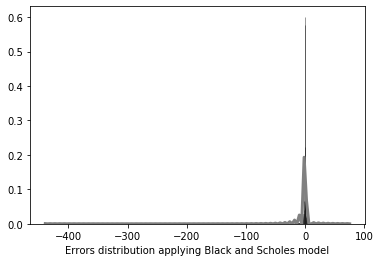

In [10]:
#Applying BS formula to test set and counting time

start = time.time()

test_ds['BS_Price']= np.where(test_ds['Type']=='call', 
                         BS_Option_Price(test_ds['UnderlyingPrice'], 
                                         test_ds['Strike'], 
                                         test_ds['TimeToMaturity'], 
                                         rf, 
                                         test_ds['IVMean'], option = 'call'), 
                         BS_Option_Price(test_ds['UnderlyingPrice'], 
                                         test_ds['Strike'], 
                                         test_ds['TimeToMaturity'], 
                                         rf, test_ds['IVMean'], option = 'put'))

#Calculating the absolute error of the model

test_ds['Absolute_error']=np.absolute(test_ds['Average Price'] - test_ds['BS_Price'])

end = time.time()

MAE = np.mean(test_ds['Absolute_error'])

print("MAE: "+ str(MAE))

print("Runtime: " + str(end - start))

#Distribution of errors plot

test_ds['Errors distribution applying Black and Scholes model']=test_ds['Average Price'] - test_ds['BS_Price']

sns.distplot(test_ds['Errors distribution applying Black and Scholes model'], hist=True, kde=True, 
             bins=int(1000), color = 'grey', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})

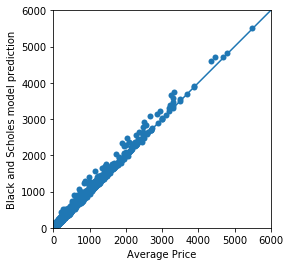

In [11]:
#Scatterplot actual vs. predicted

a = plt.axes(aspect='equal')
plt.scatter(test_ds['Average Price'], test_ds['BS_Price'], linewidths=0.001)
plt.xlabel('Average Price')
plt.ylabel('Black and Scholes model prediction')
lims = [0, 6000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

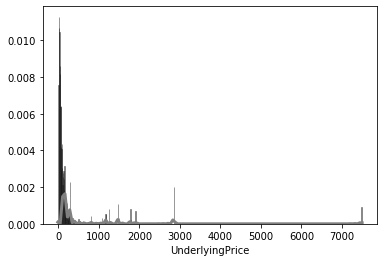

In [12]:
sns.distplot(ds['UnderlyingPrice'], hist=True, kde=True, 
             bins=int(1000), color = 'grey', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})

In [13]:
ds.head()

,UnderlyingPrice,Type,Strike,IVMean,Average Price,TimeToMaturity
0,69.59,call,42.5,1.0356,27.275,0.003968
1,69.59,put,42.5,1.2329,0.020,0.003968
2,69.59,call,45.0,1.0356,24.675,0.003968
3,69.59,put,45.0,1.2329,0.020,0.003968
4,69.59,call,47.5,1.0356,22.125,0.003968
